In [14]:
import numpy as np
from tqdm import tqdm

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

# Regularization functions
def l1_regularization(weights, alpha):
    return alpha * np.sum(np.abs(weights))

def l2_regularization(weights, alpha):
    return alpha * np.sum(weights ** 2)

# Loss function (example)
def categorical_crossentropy(predictions, targets):
    epsilon = 1e-12
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(targets * np.log(predictions + 1e-9)) / N
    return ce_loss


In [15]:
class Conv2D:
    def __init__(self, filters, kernel_size, stride=1, padding=0):
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = None
        self.bias = None
        self.grad_weights = None
        self.grad_bias = None
        self.input = None

    def initialize_parameters(self, input_shape):
        self.input_shape = input_shape
        self.weights = np.random.randn(self.filters, input_shape[1], self.kernel_size, self.kernel_size) * np.sqrt(2.0 / (input_shape[1] * self.kernel_size * self.kernel_size))
        self.bias = np.zeros((self.filters, 1))
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias)

    def forward(self, input):
        self.input = input
        batch_size, channels, height, width = input.shape
        if self.weights is None:
            self.initialize_parameters(input.shape)
        padded_input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), 'constant')
        height_out = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        width_out = (width + 2 * self.padding - self.kernel_size) // self.stride + 1
        output = np.zeros((batch_size, self.filters, height_out, width_out))

        for b in range(batch_size):
            for f in range(self.filters):
                for i in range(0, height_out):
                    for j in range(0, width_out):
                        h_start = i * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = j * self.stride
                        w_end = w_start + self.kernel_size
                        patch = padded_input[b, :, h_start:h_end, w_start:w_end]
                        output[b, f, i, j] = np.sum(patch * self.weights[f]) + self.bias[f]

        return output

    def backward(self, d_output, learning_rate):
        batch_size, _, height, width = self.input.shape
        padded_input = np.pad(self.input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), 'constant')
        d_input = np.zeros_like(padded_input)
        height_out, width_out = d_output.shape[2], d_output.shape[3]

        for b in range(batch_size):
            for f in range(self.filters):
                for i in range(0, height_out):
                    for j in range(0, width_out):
                        h_start = i * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = j * self.stride
                        w_end = w_start + self.kernel_size
                        patch = padded_input[b, :, h_start:h_end, w_start:w_end]
                        self.grad_weights[f] += d_output[b, f, i, j] * patch
                        self.grad_bias[f] += d_output[b, f, i, j]
                        d_input[b, :, h_start:h_end, w_start:w_end] += d_output[b, f, i, j] * self.weights[f]

        if self.padding != 0:
            d_input = d_input[:, :, self.padding:-self.padding, self.padding:-self.padding]

        self.weights -= learning_rate * self.grad_weights / batch_size
        self.bias -= learning_rate * self.grad_bias / batch_size

        return d_input


In [16]:
class MaxPooling2D:
    def __init__(self, pool_size=(2, 2), stride=2):
        self.pool_size = pool_size
        self.stride = stride
        self.input = None
        self.height_out = None
        self.width_out = None
    
    def forward(self, input):
        self.input = input
        batch_size, channels, height, width = input.shape
        self.height_out = (height - self.pool_size[0]) // self.stride + 1
        self.width_out = (width - self.pool_size[1]) // self.stride + 1
        
        output = np.zeros((batch_size, channels, self.height_out, self.width_out))
        
        for b in range(batch_size):
            for c in range(channels):
                for i in range(self.height_out):
                    for j in range(self.width_out):
                        h_start = i * self.stride
                        h_end = h_start + self.pool_size[0]
                        w_start = j * self.stride
                        w_end = w_start + self.pool_size[1]
                        
                        patch = input[b, c, h_start:h_end, w_start:w_end]
                        output[b, c, i, j] = np.max(patch)
        
        return output
    
    def backward(self, d_output, learning_rate):
        batch_size, channels, _, _ = self.input.shape
        d_input = np.zeros_like(self.input)
        
        for b in range(batch_size):
            for c in range(channels):
                for i in range(self.height_out):
                    for j in range(self.width_out):
                        h_start = i * self.stride
                        h_end = h_start + self.pool_size[0]
                        w_start = j * self.stride
                        w_end = w_start + self.pool_size[1]
                        
                        patch = self.input[b, c, h_start:h_end, w_start:w_end]
                        mask = (patch == np.max(patch))
                        d_input[b, c, h_start:h_end, w_start:w_end] += mask * d_output[b, c, i, j]
        
        return d_input


In [17]:
class Dense:
    def __init__(self, input_units, units, activation=None, weight_regularizer=None):
        self.input_units = input_units
        self.units = units
        self.activation = activation
        self.weight_regularizer = weight_regularizer
        
        self.weights = None
        self.bias = None
        self.grad_weights = None
        self.grad_bias = None
        self.input = None
        
        self.initialize_parameters()
        
    def initialize_parameters(self):
        # Initialize weights and bias
        self.weights = np.random.randn(self.input_units, self.units) * np.sqrt(2.0 / self.input_units)
        self.bias = np.zeros((1, self.units))
        
    def forward(self, input):
        self.input = input
        output = np.dot(input, self.weights) + self.bias
        
        if self.activation == 'relu':
            return np.maximum(0, output)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            return np.tanh(output)
        elif self.activation == 'softmax':
            exp_scores = np.exp(output)
            return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        else:
            return output  # Linear activation
    
    def backward(self, d_output, learning_rate):
        batch_size = self.input.shape[0]
        
        if self.activation == 'relu':
            grad_activation = (self.input > 0).astype(float)
        elif self.activation == 'sigmoid':
            grad_activation = sigmoid(self.input) * (1 - sigmoid(self.input))
        elif self.activation == 'tanh':
            grad_activation = 1 - np.tanh(self.input) ** 2
        elif self.activation == 'softmax':
            # Softmax gradient is handled separately in cross-entropy loss function
            grad_activation = 1
        else:
            grad_activation = 1  # Linear activation
        
        d_input = np.dot(d_output, self.weights.T) * grad_activation
        self.grad_weights = np.dot(self.input.T, d_output) / batch_size
        self.grad_bias = np.mean(d_output, axis=0, keepdims=True)
        
        if self.weight_regularizer == 'L1':
            self.grad_weights += np.sign(self.weights) * self.weight_regularizer_strength
        elif self.weight_regularizer == 'L2':
            self.grad_weights += 2 * self.weights * self.weight_regularizer_strength
        
        self.weights -= learning_rate * self.grad_weights
        self.bias -= learning_rate * self.grad_bias
        
        return d_input


In [18]:
class BatchNormalization:
    def __init__(self, epsilon=1e-5, momentum=0.9):
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = None
        self.running_var = None
        self.beta = None
        self.gamma = None
        self.grad_beta = None
        self.grad_gamma = None
        self.input = None
        self.batch_size = None
        
    def initialize(self, input_shape):
        self.gamma = np.ones((1, input_shape[0], 1, 1))
        self.beta = np.zeros((1, input_shape[0], 1, 1))
        self.running_mean = np.zeros((1, input_shape[0], 1, 1))
        self.running_var = np.ones((1, input_shape[0], 1, 1))
        
    def forward(self, input, mode='train'):
        self.input = input
        self.batch_size, self.channels, self.height, self.width = input.shape
        
        if self.gamma is None or self.beta is None:
            self.initialize((self.channels,))
        
        if mode == 'train':
            sample_mean = np.mean(input, axis=(0, 2, 3), keepdims=True)
            sample_var = np.var(input, axis=(0, 2, 3), keepdims=True)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * sample_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * sample_var
        else:
            sample_mean = self.running_mean
            sample_var = self.running_var
        
        self.x_hat = (input - sample_mean) / np.sqrt(sample_var + self.epsilon)
        output = self.gamma * self.x_hat + self.beta
        
        return output
    
    def backward(self, d_output, learning_rate):
        d_gamma = np.sum(d_output * self.x_hat, axis=(0, 2, 3), keepdims=True)
        d_beta = np.sum(d_output, axis=(0, 2, 3), keepdims=True)
        
        d_x_hat = d_output * self.gamma
        N = self.batch_size * self.height * self.width
        d_var = np.sum(d_x_hat * (self.input - self.running_mean) * (-0.5) * np.power(self.running_var + self.epsilon, -1.5), axis=(0, 2, 3), keepdims=True)
        d_mean = np.sum(d_x_hat * (-1) / np.sqrt(self.running_var + self.epsilon), axis=(0, 2, 3), keepdims=True) + d_var * np.sum(-2 * (self.input - self.running_mean), axis=(0, 2, 3), keepdims=True) / N
        
        d_input = d_x_hat / np.sqrt(self.running_var + self.epsilon) + d_var * 2 * (self.input - self.running_mean) / N + d_mean / N
        self.grad_gamma = d_gamma
        self.grad_beta = d_beta
        
        self.gamma -= learning_rate * self.grad_gamma
        self.beta -= learning_rate * self.grad_beta
        
        return d_input


In [19]:
class Activation:
    def __init__(self, activation_type):
        self.activation_type = activation_type
        self.input = None
        
    def forward(self, input):
        self.input = input
        
        if self.activation_type == 'relu':
            return np.maximum(0, input)
        elif self.activation_type == 'sigmoid':
            return 1 / (1 + np.exp(-input))
        elif self.activation_type == 'tanh':
            return np.tanh(input)
        else:
            raise ValueError(f"Activation '{self.activation_type}' is not supported.")
    
    def backward(self, d_output, learning_rate):
        if self.activation_type == 'relu':
            grad = (self.input > 0).astype(float)
        elif self.activation_type == 'sigmoid':
            grad = sigmoid(self.input) * (1 - sigmoid(self.input))
        elif self.activation_type == 'tanh':
            grad = 1 - np.tanh(self.input) ** 2
        else:
            raise ValueError(f"Activation '{self.activation_type}' is not supported.")
        
        return d_output * grad


In [20]:
class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None
        
    def forward(self, input, mode='train'):
        if mode == 'train':
            self.mask = (np.random.rand(*input.shape) >= self.dropout_rate) / (1 - self.dropout_rate)
            output = input * self.mask
        else:
            output = input
        
        return output
    
    def backward(self, d_output, learning_rate):
        d_input = d_output * self.mask
        return d_input


In [21]:
class Flatten:
    def forward(self, input):
        self.input_shape = input.shape
        batch_size = input.shape[0]
        return input.reshape(batch_size, -1)
    
    def backward(self, d_output, learning_rate):
        return d_output.reshape(self.input_shape)

In [22]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, params, gradients):
        for param, grad in zip(params, gradients):
            param -= self.learning_rate * grad

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0
        
    def update(self, params, gradients):
        if self.m is None:
            self.m = [np.zeros_like(param) for param in params]
            self.v = [np.zeros_like(param) for param in params]
        
        self.t += 1
        for i in range(len(params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gradients[i] ** 2)
            
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            params[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)


In [23]:
class VGG:
    def __init__(self):
        self.layers = [
            Conv2D(filters=64, kernel_size=3, stride=1, padding=1),
            BatchNormalization(),
            Activation('relu'),
            Conv2D(filters=64, kernel_size=3, stride=1, padding=1),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2), stride=2),
            Conv2D(filters=128, kernel_size=3, stride=1, padding=1),
            BatchNormalization(),
            Activation('relu'),
            Conv2D(filters=128, kernel_size=3, stride=1, padding=1),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2), stride=2),
            Dropout(dropout_rate=0.5),
            Flatten(),
            Dense(input_units=6272, units=10, activation='softmax')
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, d_output, learning_rate):
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate)
        return d_output

    def get_params(self):
        params = []
        for layer in self.layers:
            if hasattr(layer, 'weights'):
                params.append(layer.weights)
                params.append(layer.bias)
        return params

    def get_gradients(self):
        gradients = []
        for layer in self.layers:
            if hasattr(layer, 'grad_weights'):
                gradients.append(layer.grad_weights)
                gradients.append(layer.grad_bias)
        return gradients


In [24]:
def eval(model, x_test, y_test, batch_size=32):
    correct_num, tot_num = 0, 0
    for i in range(0, len(x_test), batch_size):
        x_batch = x_test[i: i+batch_size]
        y_batch = y_test[i: i+batch_size]

        predictions = model.forward(x_batch)
        predictions_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_batch, axis=1)

        correct_num += np.sum(predictions_classes == true_classes)
        tot_num += batch_size
    
    accuracy = correct_num / tot_num

    return accuracy


In [25]:
def train(model, x_train, y_train, x_test, y_test, optimizer, batch_size=32, epochs=10):
    num_samples = x_train.shape[0]
    num_batches = num_samples // batch_size
    
    losses, acces = [], []
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = (batch + 1) * batch_size
            
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            # Forward pass
            predictions = model.forward(x_batch)
            loss = categorical_crossentropy(predictions, y_batch)
            
            # Backward pass
            grad_output = predictions - y_batch
            model.backward(grad_output, optimizer.learning_rate)
            
            # Update parameters
            optimizer.update(model.get_params(), model.get_gradients())
            
            epoch_loss += loss
        accuracy = eval(model, x_test, y_test, batch_size)
        epoch_loss /= num_batches
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss: .4f}, Accuracy: {accuracy * 100: .2f} %")

        losses.append(epoch_loss)
        acces.append(accuracy * 100)

    return losses, acces


  5%|▌         | 1/20 [18:50<5:58:03, 1130.71s/it]

Epoch 1/20, Loss:  2.8767, Accuracy:  57.62 %


 10%|█         | 2/20 [37:41<5:39:10, 1130.60s/it]

Epoch 2/20, Loss:  0.6957, Accuracy:  71.09 %


 15%|█▌        | 3/20 [56:31<5:20:21, 1130.67s/it]

Epoch 3/20, Loss:  0.5944, Accuracy:  73.63 %


 20%|██        | 4/20 [1:15:21<5:01:26, 1130.38s/it]

Epoch 4/20, Loss:  0.3902, Accuracy:  77.73 %


 25%|██▌       | 5/20 [1:34:15<4:42:51, 1131.45s/it]

Epoch 5/20, Loss:  0.3011, Accuracy:  81.45 %


 30%|███       | 6/20 [1:53:09<4:24:12, 1132.31s/it]

Epoch 6/20, Loss:  0.2452, Accuracy:  84.57 %


 35%|███▌      | 7/20 [2:12:03<4:05:30, 1133.10s/it]

Epoch 7/20, Loss:  0.1885, Accuracy:  86.91 %


 40%|████      | 8/20 [2:30:57<3:46:38, 1133.17s/it]

Epoch 8/20, Loss:  0.1835, Accuracy:  88.09 %


 45%|████▌     | 9/20 [2:49:50<3:27:45, 1133.22s/it]

Epoch 9/20, Loss:  0.1717, Accuracy:  88.09 %


 50%|█████     | 10/20 [3:08:43<3:08:52, 1133.21s/it]

Epoch 10/20, Loss:  0.1241, Accuracy:  87.89 %


 55%|█████▌    | 11/20 [3:27:37<2:50:00, 1133.37s/it]

Epoch 11/20, Loss:  0.0976, Accuracy:  84.77 %


 60%|██████    | 12/20 [3:46:29<2:31:04, 1133.02s/it]

Epoch 12/20, Loss:  0.0830, Accuracy:  88.09 %


 65%|██████▌   | 13/20 [4:05:23<2:12:12, 1133.16s/it]

Epoch 13/20, Loss:  0.0753, Accuracy:  88.28 %


 70%|███████   | 14/20 [4:24:14<1:53:15, 1132.60s/it]

Epoch 14/20, Loss:  0.0708, Accuracy:  88.28 %


 75%|███████▌  | 15/20 [4:43:06<1:34:21, 1132.34s/it]

Epoch 15/20, Loss:  0.0564, Accuracy:  88.09 %


 80%|████████  | 16/20 [5:01:57<1:15:27, 1131.99s/it]

Epoch 16/20, Loss:  0.0415, Accuracy:  88.48 %


 85%|████████▌ | 17/20 [5:20:50<56:37, 1132.34s/it]  

Epoch 17/20, Loss:  0.0672, Accuracy:  90.62 %


 90%|█████████ | 18/20 [5:39:41<37:43, 1131.83s/it]

Epoch 18/20, Loss:  0.0587, Accuracy:  89.26 %


 95%|█████████▌| 19/20 [5:58:29<18:50, 1130.67s/it]

Epoch 19/20, Loss:  0.0296, Accuracy:  90.62 %


100%|██████████| 20/20 [6:17:20<00:00, 1132.03s/it]

Epoch 20/20, Loss:  0.0328, Accuracy:  90.62 %


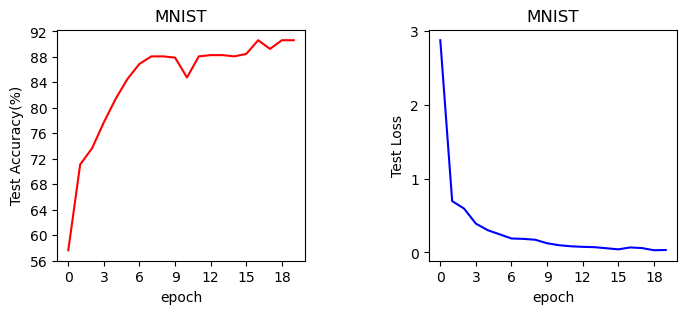

In [26]:
from matplotlib import ticker
import numpy as np
from torch.utils.data import Subset

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 数据预处理和加载
# transform = transforms.Compose(
#     [transforms.ToTensor(),|
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# trainset = torchvision.datasets.CIFAR10(root='../dataset/cifar10', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='../dataset/cifar10', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=100,
#                                          shuffle=False, num_workers=2)

transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 标准化图像数据
])

subset_train_indices = list(range(500)) # 只取前500个样本
subset_test_indices = list(range(500))

trainset = torchvision.datasets.MNIST(root='../dataset/mnist', train=True,
                                        download=True, transform=transform)
trainset = Subset(trainset, subset_train_indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../dataset/mnist', train=False,
                                       download=True, transform=transform)
testset = Subset(testset, subset_test_indices)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)


# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 转换训练数据为numpy格式
train_data = []
train_labels = []

for images, labels in trainloader:
    for i in range(len(images)):
        train_data.append(images[i].numpy())
        train_labels.append(np.eye(10)[labels[i]])

x_train = np.array(train_data)
y_train = np.array(train_labels)

# 转换测试数据为numpy格式
test_data = []
test_labels = []

for images, labels in testloader:
    for i in range(len(images)):
        test_data.append(images[i].numpy())
        test_labels.append(np.eye(10)[labels[i]])

x_test = np.array(test_data)
y_test = np.array(test_labels)

model = VGG()
optimizer = Adam(learning_rate=0.001)
losses, acces = train(model, x_train, y_train, x_test, y_test, optimizer, batch_size=32, epochs=20)

# losses = [1.5, 2.5, 3.5, 4.5, 5.5, 30.78, 45.69]
# acces = [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

_, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(range(len(acces)), acces, c='r') 
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Test Accuracy(%)")
axes[0].set_title("MNIST")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(range(len(losses)), losses, c='b')
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("Test Loss")
axes[1].set_title("MNIST")
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.subplots_adjust(wspace=0.5)
plt.show()